In [1]:
import numpy as np 
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from logistic_regression import predict, update_parameters, gradient_descent, compute_cost
raw_data = pd.read_csv('train.csv')
data = raw_data.copy()

### Refit Model
* After my original post on logistic regression I thought I could quickly cover model optimisation. 

* This was very short sighted as there is too much to cover so I'm pivoting away from that idea.

* Instead I will post a series of notes covering concepts along the way to *hopefully* improving model performance on the Kaggle Titanic dataset.

* This post is going to cover accessing performance with a binary classifier.


* Going back to where I left off, I'm going to reuse the homebrewed functions to refit model parameters except this time I'll split the data 80/20 into training & holdout sets.

* The model will be trained on the training set and it's performance will be accessing against the holdout set.

* Why do this?

* A classification model is useful when it makes accurate predictions on unseen data.

* Unseen in the sense that the data hasn't been used by the model in training.

* If we create a model we intend to deploy we need some method to access how well we think its performance will be on unseen data.

* This why some data is withheld from the model during the training phase and is used to estimate how well we expect the model to predict on unseen cases.

Model Survival as a function of Bias Term, Pclass, Age, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S.

Iteration: 0 Cost = 0.6931471805599453
Iteration: 1000 Cost = 0.52106220252457
Iteration: 2000 Cost = 0.4916651474817609
Iteration: 3000 Cost = 0.4806661916329501
Iteration: 4000 Cost = 0.4747131468102821
Iteration: 5000 Cost = 0.4707040054332811
Iteration: 6000 Cost = 0.4677153584963639
Iteration: 7000 Cost = 0.4653834488713755
Iteration: 8000 Cost = 0.46352060958013797
Iteration: 9000 Cost = 0.4620099684708816
Iteration: 10000 Cost = 0.4607709696290571

The Model Accuracy on the training data = 0.79


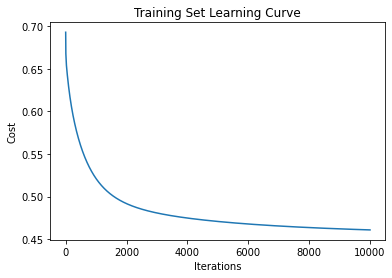

In [2]:
# Randomly shuffle data
data = data.sample(frac=1, random_state=42)

# Split 80/20 into train & holdout 
train, holdout = np.split(data, [int(.8*len(data))])

def preprocess(data):  
    # Fill missing data with mean and mode
    data.Age = data.Age.fillna(data.Age.mean())  
    data.Embarked = data.Embarked.fillna('S') 
    
    # Convert categorical features & drop unused features
    data = pd.get_dummies(data, columns = ['Sex', 'Embarked']) 
    data.drop(columns=['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Name', 'PassengerId'], inplace=True) 
    
    # Drop target & record feature names
    features = data.drop(columns=['Survived'])
    names = features.columns 
    names = names.insert(0,'Bias Term')
    
    # Convert to numpy
    features = features.to_numpy()  
    target = data['Survived'].to_numpy()
    
    # Add bias feature initalised as zeros
    features = np.column_stack((np.ones(len(features)), features)) 
    
    return(target, features, names)

target_train, features_train, names = preprocess(train)

print(f'Model Survival as a function of {", ".join(names)+"."}\n') # Print model form  

# Initalise parameters as vector of zeros
parameters = np.zeros(8)

# Fit model parameters on the training data
model_parameters, log = gradient_descent(features_train, parameters, target_train, 
                                         learning_rate=0.008, iterations=10001)

# Make predictions on the training data
predictions = predict(features_train, model_parameters)
threshold = 0.50
binary_predictions = [1 if prediction >= threshold else 0 for prediction in predictions]
binary_predictions = np.asarray(binary_predictions)

# Compute model accurancy 
accurancy = sum(target_train == binary_predictions)/len(target_train)
print(f'\nThe Model Accuracy on the training data = {accurancy:0.2f}')

# Plot learning curve
fig, ax = plt.subplots()
ax.plot(log)
ax.set(title='Training Set Learning Curve', xlabel='Iterations', ylabel='Cost')
plt.show()

### Accuracy, Precision, Recall & F Score

* The first metric we can look at is the percentage of passengers we correctly classified as having survived or not, the model's accuracy.

* Accuracy is intuitive and for a balanced binary classification problem, where we expect 50% of our cases to be positive and 50% negative, it a useful performance gauge.

* The more imbalanced the classification the less useful accuracy becomes. 

* If 99% of banking transactions aren't fraudulent then we just predict every transaction is honest and we'll be 99% accurate.

* Our dataset is 38/62 survival/deceased so let's consider some other performance metrics.


* Let's imagine it's the day after the Titanic met its maker - 16th of April 1912. 

* I'm at the docks in Belfast offering predictions to grieving family members on whether their loved ones have survived the shipwreck given some basic information about them - age, sex, their passenger class and where they embarked from.

* A father approaches, hands over the necessary information and I inform him that the prediction is that his son has survived.

* Changing places what would I think about this?

* The first thing that comes to mind is to ask *OK what's the chances your model's prediction is wrong?*

* To answer this question I need more granularity about the models predictions.

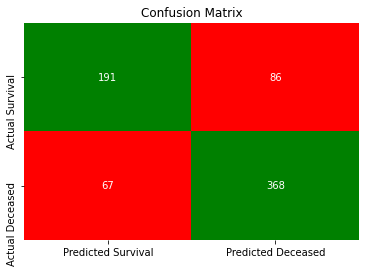

In [3]:
# For both class instances, how many did we correctly & incorrectly classify
true_positives = sum((binary_predictions == 1) & (target_train == 1))
false_negatives = sum((binary_predictions == 0) & (target_train == 0))
false_positives = sum((binary_predictions == 1) & (target_train != 1))
true_negatives = sum((binary_predictions == 0) & (target_train != 0))

# Plot confusion matrix
confusion = np.array([(true_positives, true_negatives), (false_positives, false_negatives)])
fig, ax = plt.subplots()
ax = sb.heatmap(confusion, annot=True, fmt="d", cbar=False,
               xticklabels=['Predicted Survival', 'Predicted Deceased'],
               yticklabels=['Actual Survival', 'Actual Deceased'],
               cmap=['red', 'green','green'])
ax.set(title='Confusion Matrix')
plt.show()

* I took a data science course with General Assembly and I remember having to talk the class through a confusion matrix and being confused myself. 

* It's not that the concepts are that challenging, it's that the terms sound oxymoronic coming out of your mouth. 

* Concise use of the terms is a system 2 task and if you rattle through it with system 1 your going to make mistakes.

* I digress, back to the point.



* Above we have a confusion matrix showing the count of classifications made correctly in the green diagonal.

* On the bottom left in red we have passengers where we predicted survival incorrectly and in red top right where we incorrectly predicted deceased.

* Using this breakdown of our predictions we can go back to the original query, what's the chances the model's prediction is wrong given it's predicted survival?

* We sum the total survival predictions as the ones we made correctly and the ones we made incorrectly 

* True Positives + False Positives = 189 + 64 =  253 

* We can express our incorrect predictions as a percentage of our total survival predictions.

* False Positives / (True Positives + False Positives) = 64/253 = 25.29%

* So I guess our response to the distressed father is that we got this specific prediction wrong in 25.29% of cases.



* We are comparing the models erroneous classifications relative to the total predictions for that classification.

* In statistics the concept of accessing classification performance relative to the classifications made is the precision.

* Precision is calculated relative to the model's classifications of the positive class, in this case that would be survival.

* So the formula is Precision = True Positives / (True Positives + False Positives). 



* We want to make precise predictions especially in the situation above, a lack a precision will give false hope.

* All else equal we can increase precision in logistic regression by increasing the threshold above which we predict the positive class. 

* Using the model above if we amend the threshold to > 90% output to predict survival we get a precision of 96%.

* On predicting survival in the training set the model is really precise, 96% of survival predicts result in survival.

* However given this threshold, we don't make many predictions for survival.



* Let's go back to the docks with our recalibrated model. 

* After umming and ahing we now inform the gentleman that we now predict that his son no longer made it, given they don't meet our new ultra high precision threshold. 

* We explain that the model only predicts survival when it's very certain.

* What might he have to say about this.

* Given we know we are going to much fewer survival predictions we should check the percentage of actual survivors we correctly classified in training.


* With a threshold of 90% we will classify 8% of the total population of survivors in the training set.

* Ek, that certainly doesn't sound good.

* Amending the threshold allowed us to be 96% certain we were correct when identifying survivors, the problem is that we only identify 8% of survivors in training.

* Now this metric can be abused just like precision. 

* If predict that everyone survives, then we will have correctly classified all the survivors in the training set. 

* But then... see where I'm going with this.


* Both of these metrics give us a different lens with which to access model performance.

* Their performance can be manipulated but it's a zero sum game so all else equal increases precision will reduce recall.

* There is no right answer to what metric should be the priority and instead a trade off is required that will depend on the problem your model is trying to solve.

* I can imagine a model used to hand out criminal justice requiring high precision when classifying a criminal at the expense of recall.

* Equally a model used to detect fraudulent transactions may accept a low precision in favor of classifying all fraudulent transactions as fraud.


* This is starting to make sense.

* So what metric will I use to access the performance of our model? 

* In our situation I want to make precise predictions when we predict survival and also classify a respectable percentage of the total survivors. 

* I don't have an operational justification to favor precision over recall or vice versa.



* A blend of precision and recall is known as the F score, calculated as the harmonic mean.

* I know from the CFA exams the harmonic mean will always be less than or equal to the arithmetic mean.

* Situations where the harmonic is less than the arithmetic result from the harmonic punishing imbalances to a greater extent.

* This is property that makes it useful in balancing the trade off between precision and recall.

In [4]:
# Dummy values
dummy_precision = 0.9
dummy_recall = 0.1

# Calculate different mean values, note harmonic = F score
arithmatic = (dummy_precision + dummy_recall) / 2
harmonic = (dummy_precision * dummy_recall)/(dummy_precision + dummy_recall)

print(f'The harmonic mean {harmonic:0.2f}, is less than the arithmatic {arithmatic:0.2f}')

The harmonic mean 0.09, is less than the arithmatic 0.50


* To conclude this theory heavy post, I will be using the F score as my performance metric for the Titanic model.
* Below is a summary of the performance on the training and holdout sets.

In [9]:
# Return performance metrics of interest in a dictionary 
def guage_performance(features, parameters, test, threshold=0.5):
    # Make predictions
    predictions = predict(features, parameters)
    binary_predictions = [1 if prediction >= threshold else 0 for prediction in predictions]
    binary_predictions = np.asarray(binary_predictions)
    
    # Compute model accurancy 
    accurancy = sum(test == binary_predictions)/len(test)
    
    # Breakdown of predictions
    true_positive = sum((binary_predictions == 1) & (test == 1))
    false_negative = sum((binary_predictions == 0) & (test == 0))
    false_positive = sum((binary_predictions == 1) & (test != 1))
    true_negative = sum((binary_predictions == 0) & (test != 0))

    # Compute performance metrics
    recall = true_positive/(true_positive + true_negative)
    precision = true_positive/(true_positive + false_positive)
    F_score = 2 * (precision * recall)/(precision + recall)
    
    # Results dict_
    performance = dict()
    performance['accurancy'] = accurancy
    performance['recall'] = recall
    performance['precision'] = precision
    performance['F_score'] = F_score
    
    return  performance

#### Performance Comparison

In [18]:
# Training set performance 
training_performance = guage_performance(features_train, parameters, target_train)

# Holdout set performance 
target_test, features_test, names = preprocess(holdout)
holdout_performance = guage_performance(features_test, parameters, target_test)

print(f'Training Set Performance')
for key, value in training_performance.items():
    print(f'{key.capitalize()}: {value:0.2f}')
print(f'\nHoldout Set Performance')
for key, value in holdout_performance.items():
    print(f'{key.capitalize()}: {value:0.2f}')

Training Set Performance
Accurancy: 0.79
Recall: 0.69
Precision: 0.74
F_score: 0.71

Holdout Set Performance
Accurancy: 0.83
Recall: 0.74
Precision: 0.77
F_score: 0.76
